<div class="alert alert-info">

<b>Программа семинара: </b>

Лекция: анализ собранных данных. (финансовые данные)

<img align=center src="http://univer-nn.ru/econometrica/vremennoi3.jpg"  width=600>


# Кластеризация финансового рынка - Finance clustering 

## Yahoo Finance

https://finance.yahoo.com/

In [1]:
# !pip install yfinance 

In [2]:
import sys
sys.path.append(
    "../"
)

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import time
from tqdm.autonotebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from selenium import webdriver
import yfinance as yf

In [64]:
def get_info(ticker_obj):
    info_keys = ['shortName', 'sector', 'industry', 'country', 'market']
    info_values = []
    for key in info_keys:
        info_values.append(ticker_obj.info.get(key, None))
    return dict(zip(info_keys, info_values))

In [65]:
msft = yf.Ticker("MSFT")
msft.history()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-09-30,285.709991,287.829987,281.619995,281.920013,32325800,0,0
2021-10-01,282.119995,289.980011,281.290009,289.100006,30086300,0,0
2021-10-04,287.399994,287.750000,280.250000,283.109985,31350700,0,0
2021-10-05,284.049988,290.399994,284.049988,288.760010,24993000,0,0
2021-10-06,285.779999,293.630005,285.510010,293.109985,28002600,0,0
2021-10-07,295.179993,296.640015,293.920013,294.850006,20430500,0,0
2021-10-08,296.220001,296.640015,293.760010,294.850006,17680300,0,0
2021-10-11,292.920013,297.970001,292.750000,294.230011,19298600,0,0
2021-10-12,295.339996,295.440002,292.350006,292.880005,17974100,0,0


## In case you need all tickers

In [66]:
all_tickers = pd.read_csv(
    'https://raw.githubusercontent.com/shilewenuw/get_all_tickers/master/get_all_tickers/tickers.csv', 
    header=None,
    error_bad_lines=False
)

all_tickers = all_tickers.values.reshape(-1)
print(len(all_tickers))
print(all_tickers[:4])

2762
['DDD' 'MMM' 'WBAI' 'WUBA']


## Loading interesting tickers

In [67]:
def load_with_selenium(url, chromedriver_path='../src/chromedriver.exe'):  # https://chromedriver.chromium.org/downloads
    driver = webdriver.Chrome(chromedriver_path)
    driver.get(url)
    driver.implicitly_wait(2)
    df = pd.read_html(driver.find_element_by_tag_name("table").get_attribute('outerHTML'))[0]
    driver.close()
    return df

# chromedriver_path - путь до вашего хром драйвера, его нужно предварительно скачать 

In [68]:
n_group = 25

trending = load_with_selenium(f"https://finance.yahoo.com/trending-tickers?count={n_group}")
most_active = load_with_selenium(f"https://finance.yahoo.com/most-active?count={n_group}")
gainers = load_with_selenium(f"https://finance.yahoo.com/gainers?count={n_group}")
losers = load_with_selenium(f"https://finance.yahoo.com/losers?count={n_group}")

In [70]:
trending.head(10)

,Symbol,Name,Last Price,Market Time,Change,% Change,Volume,Market Cap,Intraday High/Low,52 Week Range,Day Chart
0,TSLA,"Tesla, Inc.",1114.000000,4:00PM EDT,36.960000,+3.43%,29.448M,1.119T,NaN,NaN,NaN
1,BKKT,"Bakkt Holdings, Inc.",42.520000,4:00PM EDT,16.920000,+66.09%,69.714M,2.125B,NaN,NaN,NaN
2,BTBT,"Bit Digital, Inc.",14.250000,4:00PM EDT,4.200000,+41.79%,11.589M,795.398M,NaN,NaN,NaN
3,MSFT,Microsoft Corporation,331.620000,4:00PM EDT,7.270000,+2.24%,33.621M,2.49T,NaN,NaN,NaN
4,QS,QuantumScape Corporation,28.940000,4:00PM EDT,3.540000,+13.94%,41.643M,12.226B,NaN,NaN,NaN
5,SHIB-USD,SHIBA INU USD,0.000074,7:12AM BST,0.000002,+2.25%,12.245B,40.468B,NaN,NaN,NaN
6,MTTR,"Matterport, Inc.",22.450000,4:00PM EDT,3.450000,+18.16%,12.822M,5.432B,NaN,NaN,NaN
7,GREE,Greenidge Generation Holdings Inc.,27.190000,4:00PM EDT,6.870000,+33.81%,26.436M,1.051B,NaN,NaN,NaN
8,^GSPC,S&P 500,4605.380000,5:03PM EDT,8.960000,+0.19%,2.346B,NaN,NaN,NaN,NaN
9,OCGN,"Ocugen, Inc.",11.840000,4:00PM EDT,1.360000,+12.98%,51.712M,2.353B,NaN,NaN,NaN


In [71]:
# Исключим пересечения. Возьмем только уникальные тикиты
interesting_tickers = set()

for df in [trending, most_active, gainers, losers]:
    interesting_tickers = interesting_tickers.union(set(df['Symbol']))
    
interesting_tickers = list(interesting_tickers)
print(interesting_tickers[:4])
print(len(interesting_tickers))

['AUPH', 'NVDA', 'TEAM', 'FUTU']
93


In [77]:
load = False # switch on to True

if load:
    full_ticker_data = []
    for ticker in tqdm(interesting_tickers):
        try:
            ticker_obj = yf.Ticker(ticker)
            close_price = ticker_obj.history(period='1mo', interval='1d')['Close'].to_dict()
            info = get_info(ticker_obj)
            info.update(close_price)
            full_ticker_data.append(info)
        except Exception as e:
            print(e)
            continue
        
    full_ticker_df = pd.DataFrame(full_ticker_data)
    full_ticker_df.to_csv("full_ticker_df_month_10_2021.csv")

else: 
    full_ticker_df = pd.read_csv("full_ticker_df_month_10_2021.csv", index_col=0)
    datetime_columns = pd.to_datetime(full_ticker_df.columns[5:])
    full_ticker_df.columns = list(full_ticker_df.columns[:5]) + list(datetime_columns)

In [78]:
full_ticker_df.head()

,shortName,sector,industry,country,market,2021-09-30 00:00:00,2021-10-01 00:00:00,2021-10-04 00:00:00,2021-10-05 00:00:00,2021-10-06 00:00:00,...,2021-09-29 00:00:00,2021-10-02 00:00:00,2021-10-03 00:00:00,2021-10-09 00:00:00,2021-10-10 00:00:00,2021-10-16 00:00:00,2021-10-17 00:00:00,2021-10-23 00:00:00,2021-10-24 00:00:00,2021-10-30 00:00:00
0,Aurinia Pharmaceuticals Inc,Healthcare,Biotechnology,Canada,us_market,22.129999,21.809999,21.090000,21.280001,18.850000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HEXO CORP,Healthcare,Drug Manufacturers—Specialty & Generic,Canada,ca_market,2.320000,2.290000,2.170000,2.270000,2.160000,...,2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Atlassian Corporation Plc,Technology,Software—Application,Australia,us_market,391.420013,392.220001,382.709991,389.940002,395.190002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Futu Holdings Limited,Financial Services,Capital Markets,Hong Kong,us_market,91.019997,90.500000,81.629997,84.790001,83.389999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Tuya Inc.,Technology,Software—Infrastructure,China,us_market,9.070000,8.710000,8.490000,8.540000,8.310000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
full_ticker_df.isnull().sum(axis=1)

0     10
1     10
2     10
3     10
4     10
      ..
81    10
82    10
83    10
84    10
85    10
Length: 86, dtype: int64

In [80]:
full_ticker_df = full_ticker_df.iloc[:, :-15] # Выбросим пустые столбцы

In [81]:
prices = full_ticker_df.iloc[:, 5:].T

In [82]:
prices = prices.fillna(method='backfill')  #Заполним пропуски
prices = prices.fillna(method='ffill')

In [83]:
full_ticker_df = full_ticker_df.iloc[:, :5].join(prices.T) #Выкинуть пропуски

In [84]:
full_ticker_df.dropna(inplace=True)

In [85]:
full_ticker_df.shape

(78, 22)

# Время провернуть кластерный анализ по финансовом рынке

In [90]:
full_ticker_df.sample(15)

,shortName,sector,industry,country,market,2021-09-30 00:00:00,2021-10-01 00:00:00,2021-10-04 00:00:00,2021-10-05 00:00:00,2021-10-06 00:00:00,...,2021-10-11 00:00:00,2021-10-12 00:00:00,2021-10-13 00:00:00,2021-10-14 00:00:00,2021-10-15 00:00:00,2021-10-18 00:00:00,2021-10-19 00:00:00,2021-10-20 00:00:00,2021-10-21 00:00:00,2021-10-22 00:00:00
18,Momentive Global Inc.,Technology,Software—Application,United States,us_market,19.600000,19.860001,19.910000,19.910000,20.610001,...,23.950001,23.760000,24.100000,24.320000,24.590000,24.400000,24.400000,24.299999,24.540001,24.370001
49,FEDERAL HOME LOAN MORTGAGE CORP,Financial Services,Mortgage Finance,United States,us_market,2.450000,2.350000,2.300000,2.200000,2.200000,...,2.110000,2.110000,2.140000,2.137500,2.100000,2.100000,2.250000,2.170000,2.300000,2.255000
16,"Bakkt Holdings, Inc.",Technology,Software—Infrastructure,United States,us_market,8.760000,8.760000,8.760000,8.760000,8.760000,...,8.760000,8.760000,8.760000,8.760000,8.760000,8.760000,8.490000,8.170000,8.030000,9.150000
5,"Banco Santander Mexico, S.A., I",Financial Services,Banks—Regional,Mexico,us_market,5.730000,5.720000,5.650000,5.670000,5.710000,...,5.650000,5.650000,5.650000,5.690000,5.720000,5.620000,5.660000,5.740000,5.680000,5.700000
37,"Bit Digital, Inc.",Technology,Software—Application,United States,us_market,7.230000,8.070000,7.590000,10.350000,11.220000,...,11.860000,10.680000,11.030000,10.700000,11.220000,10.960000,11.350000,11.820000,11.000000,10.170000
53,AT&T Inc.,Communication Services,Telecom Services,United States,us_market,26.495712,26.642857,26.731142,26.829239,26.789999,...,26.030001,25.430000,25.299999,25.620001,25.700001,25.330000,25.590000,25.910000,25.760000,25.490000
71,Realogy Holdings Corp.,Real Estate,Real Estate Services,United States,us_market,17.540001,18.040001,17.549999,18.129999,18.020000,...,18.870001,18.809999,20.299999,20.459999,19.990000,20.000000,20.180000,20.650000,19.620001,19.280001
50,"Roku, Inc.",Communication Services,Entertainment,United States,us_market,313.350006,314.459991,296.859985,304.510010,321.690002,...,319.600006,320.000000,329.220001,328.920013,324.380005,344.459991,344.450012,338.929993,333.829987,321.880005
57,"Guardforce AI Co., Limited",Industrials,Security & Protection Services,Thailand,us_market,3.960000,3.930000,3.510000,3.500000,3.660000,...,3.440000,3.280000,3.180000,3.210000,3.470000,2.900000,2.750000,2.400000,2.460000,2.260000
46,"Houlihan Lokey, Inc.",Financial Services,Capital Markets,United States,us_market,92.099998,93.449997,94.870003,97.910004,98.180000,...,98.099998,98.480003,98.919998,101.080002,101.300003,103.629997,104.709999,103.599998,102.309998,103.220001


## Scaling everything

In [87]:
scaler = StandardScaler()
tickers_scaled = scaler.fit_transform(full_ticker_df.iloc[:, 5:].T).T

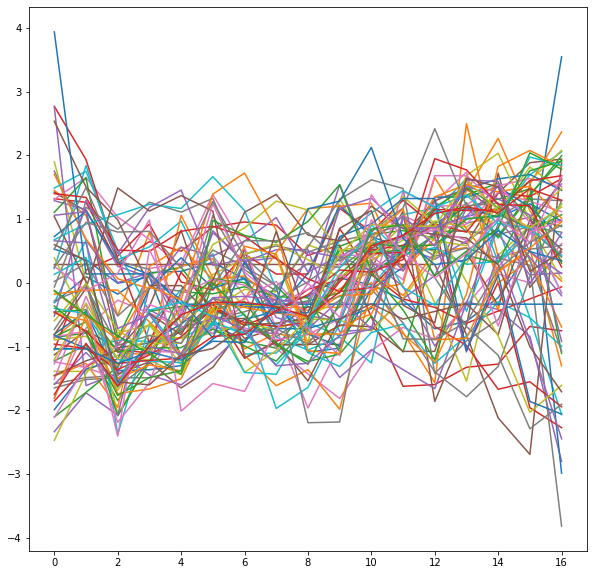

In [88]:
plt.figure(figsize=(10, 10))
plt.plot(tickers_scaled.T);

# Обычный KMeans

<div class="alert alert-info">
    
Возьмем сегодня `TimeSeriesKMeans`, а не просто `KMeans`. (Оба из `sklearn`)

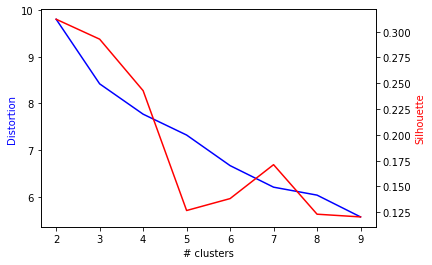

In [91]:
distortions = []
silhouette = []
K = range(2, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="euclidean", n_jobs=6, max_iter=10, n_init=5)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_, metric="euclidean"))
    # silhouette_score считает насколько чисты класстеры
    
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(K, distortions, 'b-')
ax2.plot(K, silhouette, 'r-')

ax1.set_xlabel('# clusters')
ax1.set_ylabel('Distortion', color='b')
ax2.set_ylabel('Silhouette', color='r')

plt.show()

In [103]:
n_clusters = 5
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", n_jobs=6, max_iter=10)
ts_kmeans.fit(tickers_scaled)

TimeSeriesKMeans(max_iter=10, n_clusters=5, n_jobs=6)

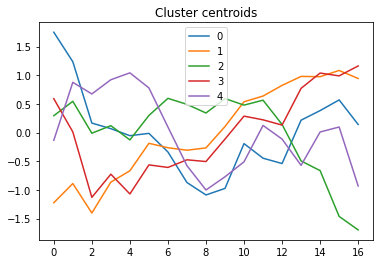

In [104]:
for cluster_number in range(n_clusters): # Построим усредненные ряды внутри каждого кластера
    plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids") # Быки и медведи
plt.legend()
plt.show()

In [105]:
full_ticker_df['cluster'] = ts_kmeans.predict(tickers_scaled)
pd.DataFrame(full_ticker_df.groupby('cluster')['sector'].value_counts())

sector
cluster sector                        
0       Healthcare                   3
        Technology                   3
        Communication Services       2
        Financial Services           2
        Consumer Cyclical            1
1       Technology                   9
        Financial Services           8
        Consumer Cyclical            5
        Communication Services       4
        Healthcare                   4
        Industrials                  3
        Real Estate                  2
        Consumer Defensive           1
        Energy                       1
2       Basic Materials              2
        Technology                   2
        Communication Services       1
        Consumer Cyclical            1
        Consumer Defensive           1
        Energy                       1
        Financial Services           1
        Industrials                  1
3       Technology                   5
        Healthcare                   4
        Basic Materials              1
        Consumer Cyclical            1
        Consumer Defensive           1
        Financial Services           1
        Industrials                  1
4       Financial Services           4
        Communication Services       1
        Technology                   1

In [106]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),
        4,
        figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[5:-1])
        ax[index].set_title(f"{row.shortName}\n{row.sector}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

                          Cluster number: 0


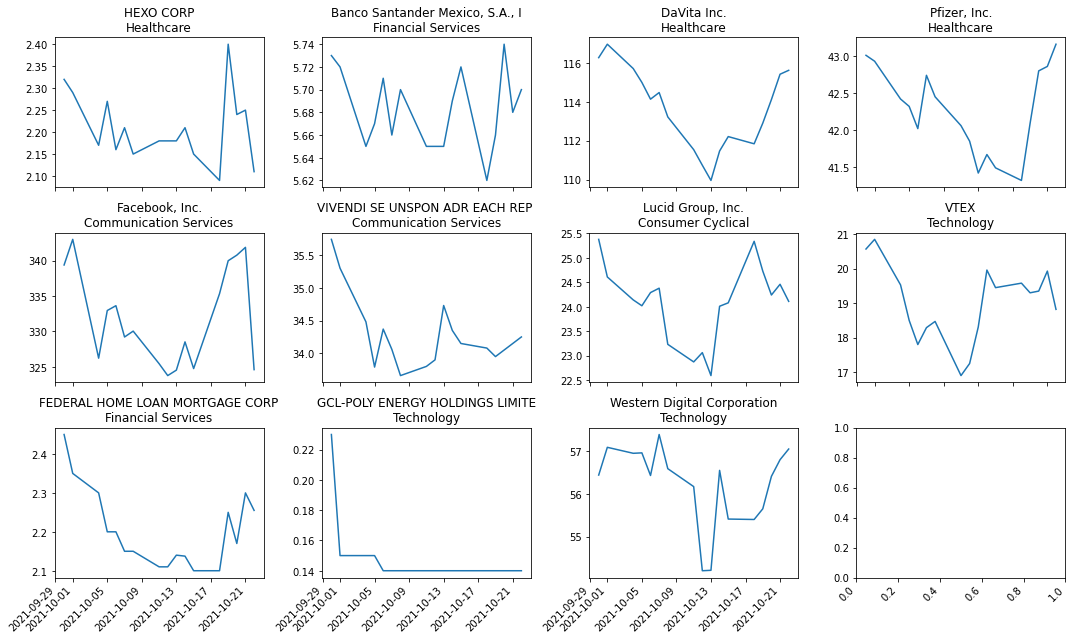

                          Cluster number: 1


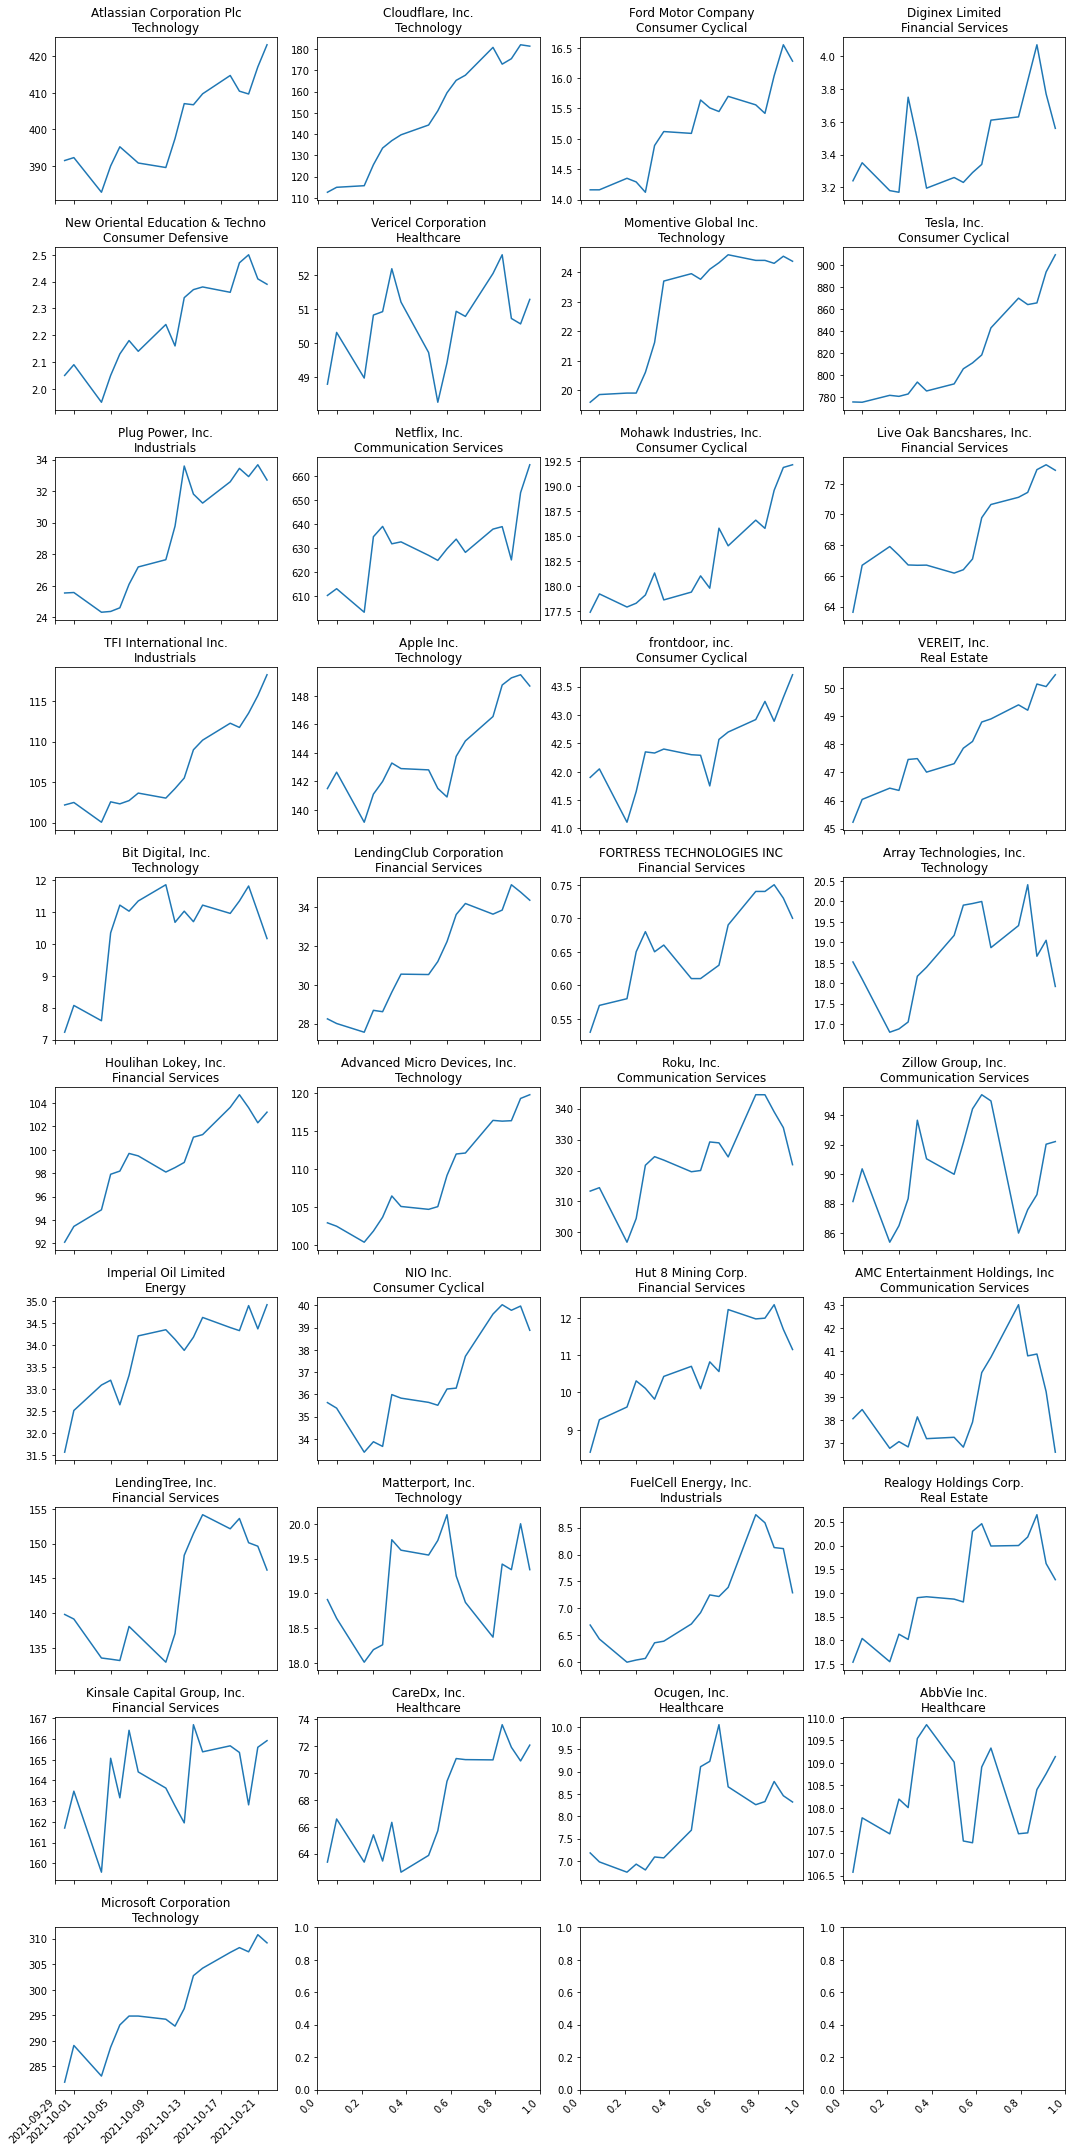

                          Cluster number: 2


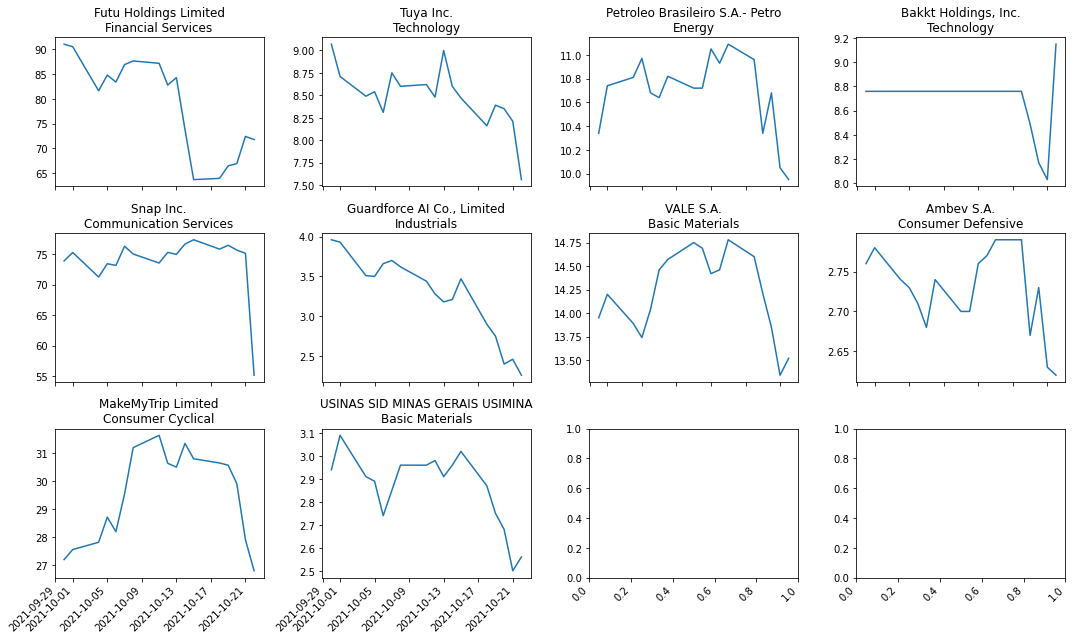

                          Cluster number: 3


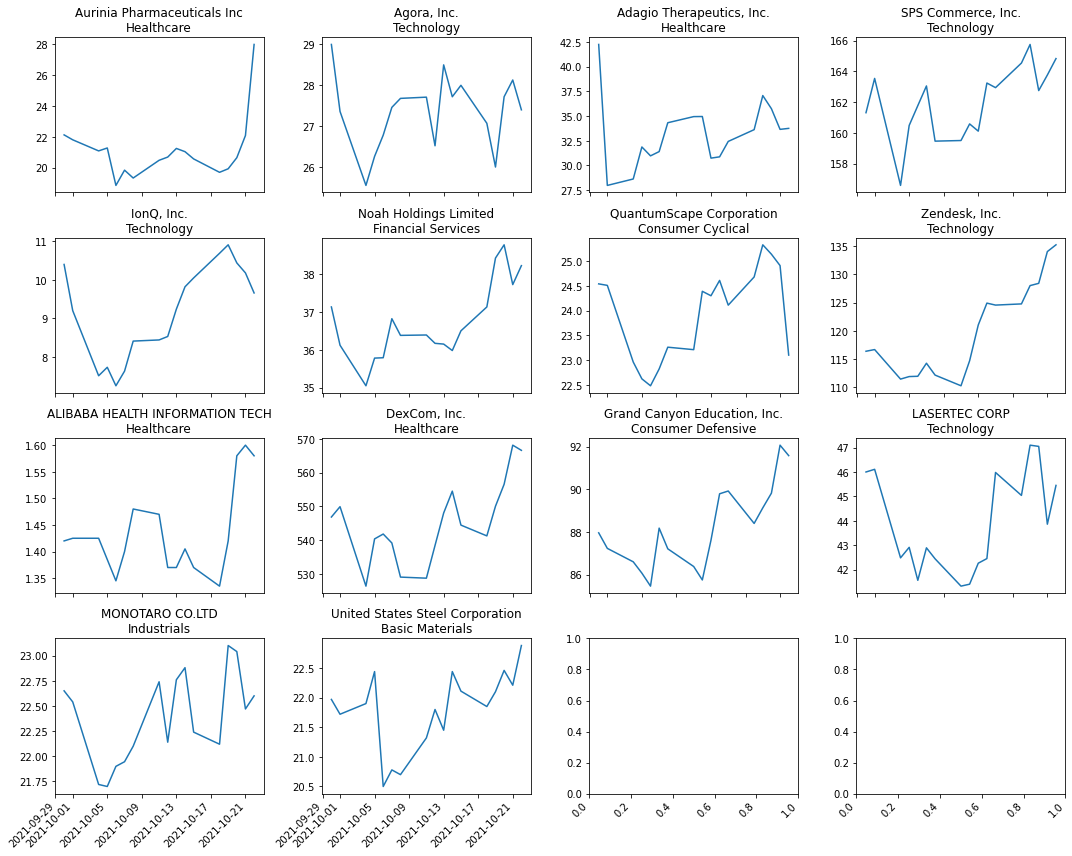

                          Cluster number: 4


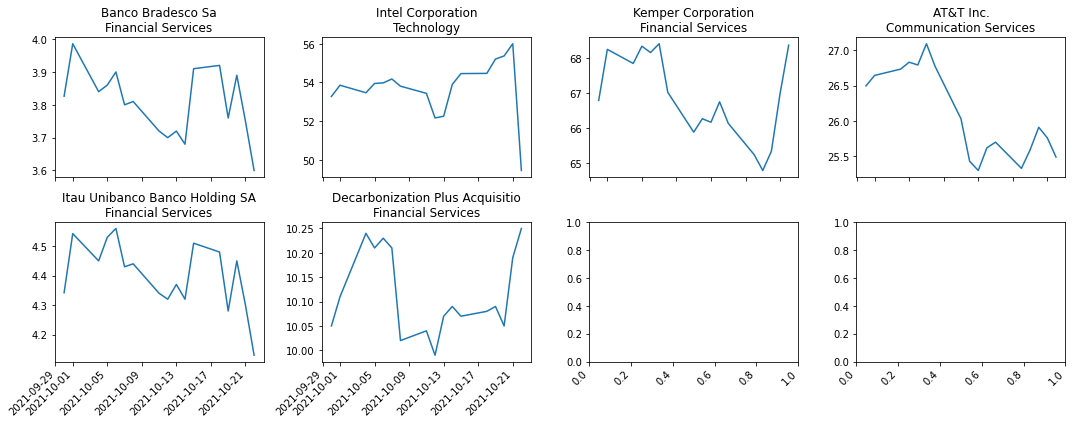

In [107]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(full_ticker_df[full_ticker_df.cluster==cluster])

# DTW - Dynamic Time Warping

Описание на Википедии: https://en.wikipedia.org/wiki/Dynamic_time_warping

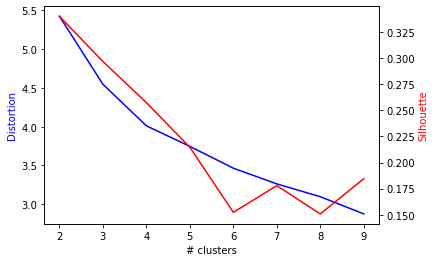

In [108]:
distortions = []
silhouette = []
K = range(2, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="dtw", n_jobs=6, max_iter=10, n_init=5)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_, metric="dtw"))
    
    # silhouette_score считает насколько чисты класстеры
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

    
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(K, distortions, 'b-')
ax2.plot(K, silhouette, 'r-')

ax1.set_xlabel('# clusters')
ax1.set_ylabel('Distortion', color='b')
ax2.set_ylabel('Silhouette', color='r')

plt.show()

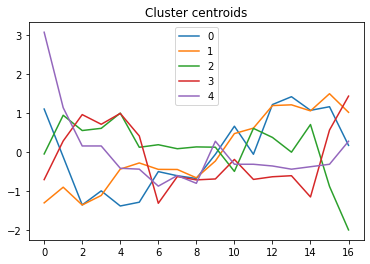

In [109]:
n_clusters = 5
ts_kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=6, max_iter=10)
ts_kmeans_dtw.fit(tickers_scaled)

for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans_dtw.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [110]:
full_ticker_df['cluster'].value_counts()

1    37
3    14
0    11
2    10
4     6
Name: cluster, dtype: int64

In [111]:
full_ticker_df['cluster'] = ts_kmeans_dtw.predict(tickers_scaled)
pd.DataFrame(full_ticker_df.groupby('cluster')['sector'].value_counts())

sector
cluster sector                        
0       Technology                   5
        Healthcare                   3
        Communication Services       2
        Consumer Cyclical            2
        Financial Services           2
        Industrials                  1
1       Technology                   8
        Financial Services           6
        Consumer Cyclical            5
        Industrials                  3
        Communication Services       2
        Consumer Defensive           2
        Healthcare                   2
        Real Estate                  2
        Energy                       1
2       Financial Services           3
        Basic Materials              2
        Communication Services       2
        Technology                   2
        Consumer Cyclical            1
        Consumer Defensive           1
        Energy                       1
        Healthcare                   1
        Industrials                  1
3       Healthcare                   5
        Financial Services           4
        Technology                   4
        Basic Materials              1
        Communication Services       1
4       Communication Services       1
        Financial Services           1
        Technology                   1

                          Cluster number: 0


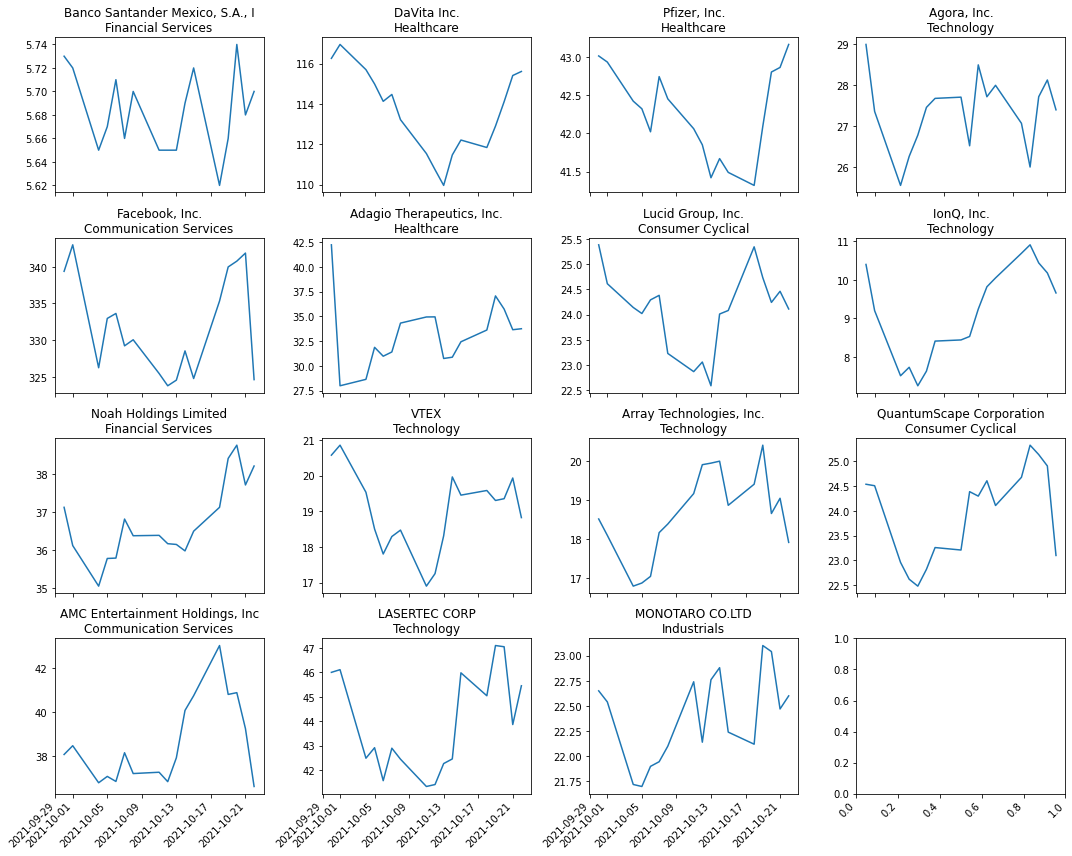

                          Cluster number: 1


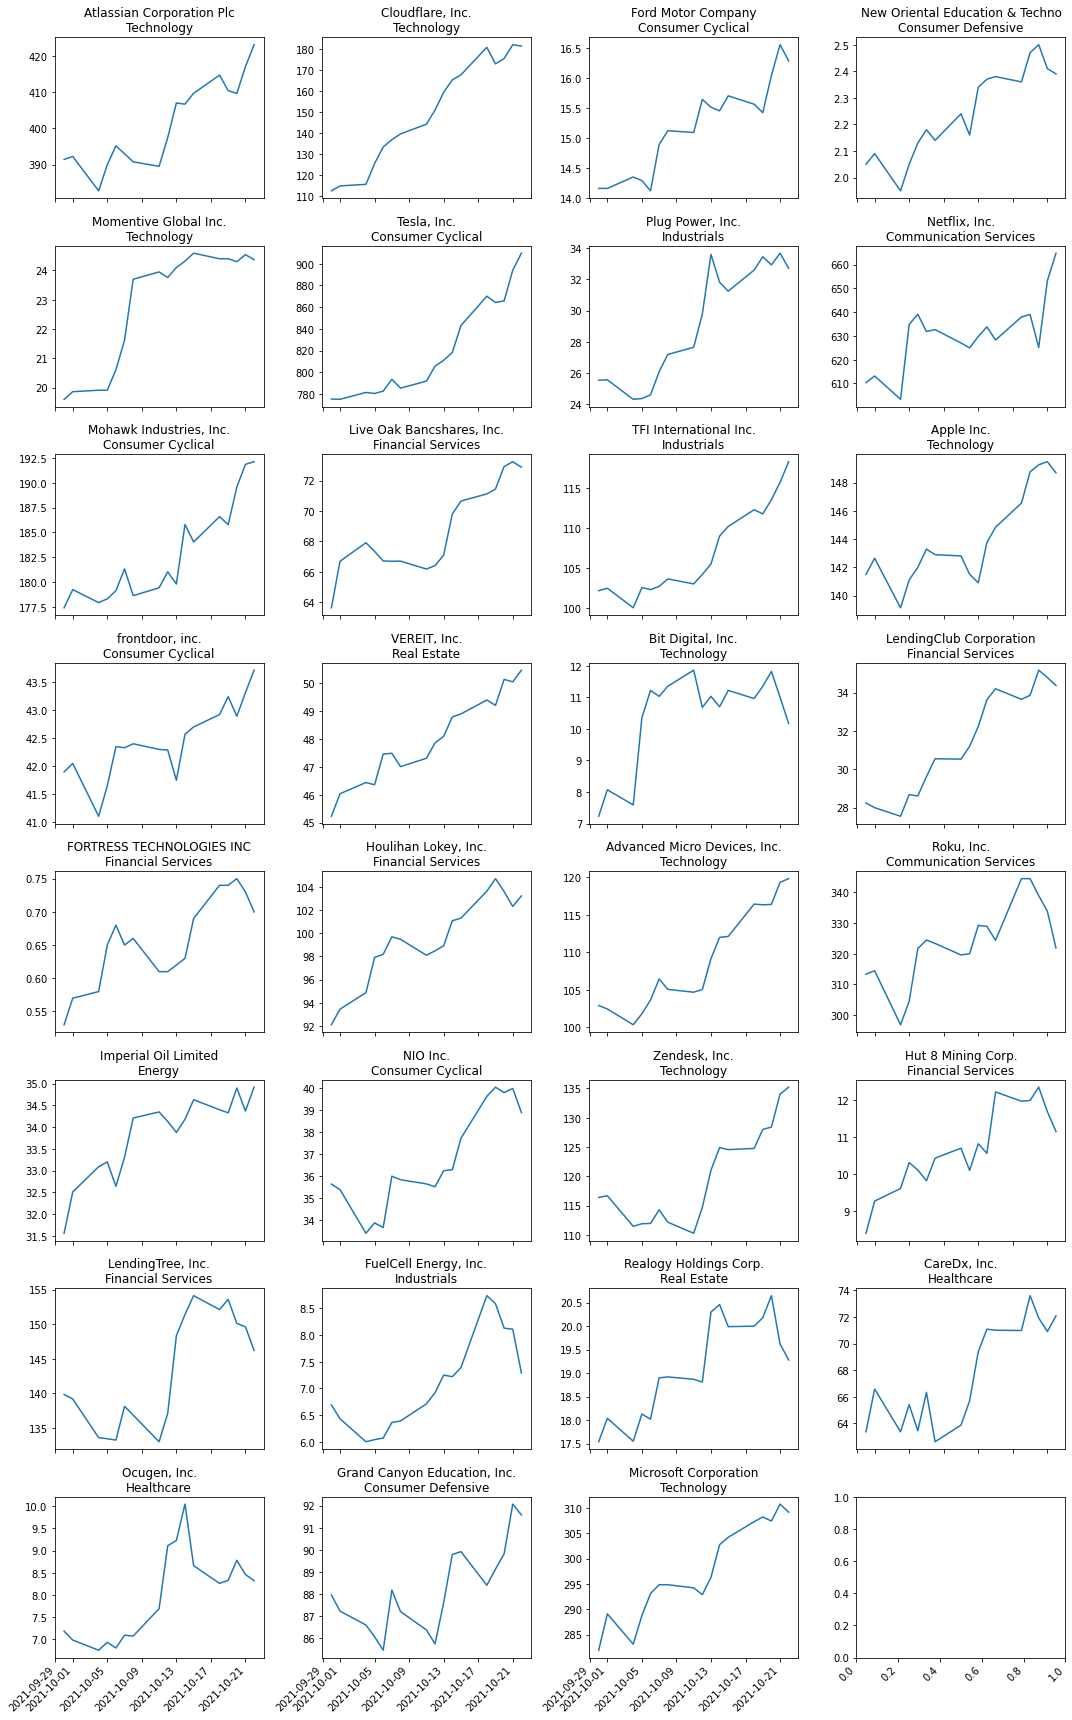

                          Cluster number: 2


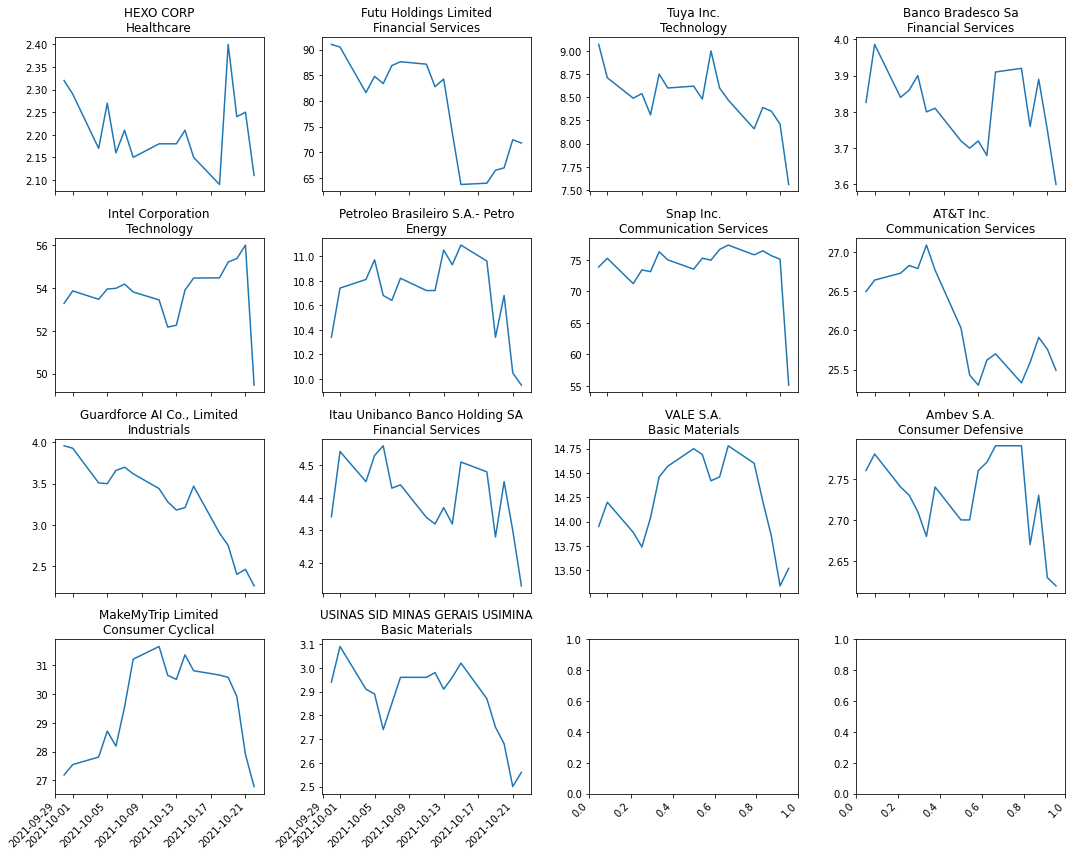

                          Cluster number: 3


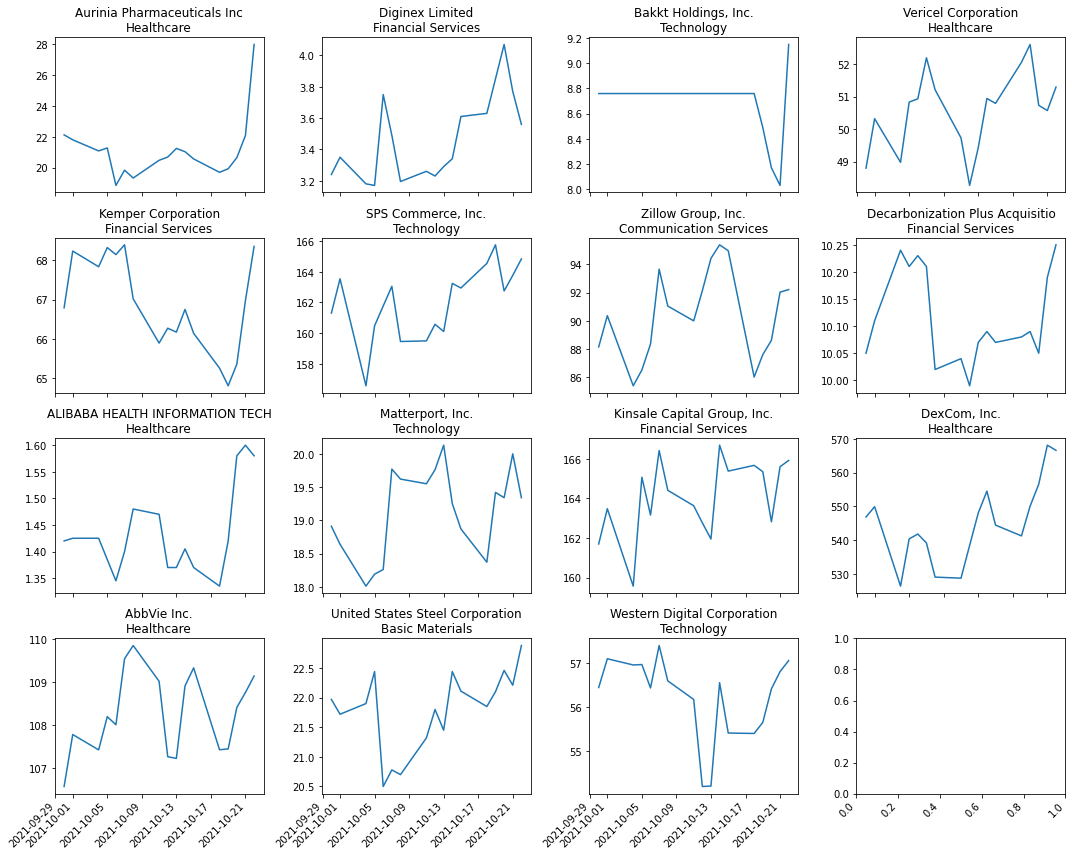

                          Cluster number: 4


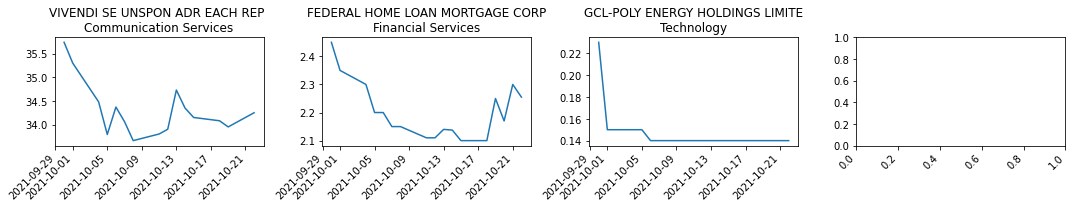

In [112]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(full_ticker_df[full_ticker_df.cluster==cluster])